In [79]:
def start_signature():
    print("="*40)
    print("START OF NOTEBOOK — AT")
    print("="*40)

start_signature()


START OF NOTEBOOK — AT


In [80]:
import pandas as pd
import numpy as np

# lets look at the base table - transfers 
df_transfers = pd.read_csv(r'C:\Users\arpitha_work\Downloads\TRU MSCDS\Sem 3\Graduate Project\MIMIC\mimic-iv-3.1\hosp\transfers.csv')
df_transfers.head()

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27
2,10000032,22595853.0,36904543,discharge,UNKNOWN,2180-05-07 17:21:27,NaN
3,10000032,22841357.0,34100253,discharge,UNKNOWN,2180-06-27 18:49:12,NaN
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12


In [81]:
# I want to know the unique number of patients and unique admissions 

unique_patients = df_transfers["subject_id"].nunique()
unique_admissions = df_transfers["hadm_id"].nunique()
unique_transfers = df_transfers["transfer_id"].nunique()
print("the no of unique patients :", unique_patients)
print(" the no of unique admissions :", unique_admissions)
print(" the no of unique transfers :", unique_transfers)

the no of unique patients : 364627
 the no of unique admissions : 546024
 the no of unique transfers : 2413581


In [82]:
df_transfers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413581 entries, 0 to 2413580
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   subject_id   int64  
 1   hadm_id      float64
 2   transfer_id  int64  
 3   eventtype    object 
 4   careunit     object 
 5   intime       object 
 6   outtime      object 
dtypes: float64(1), int64(2), object(4)
memory usage: 128.9+ MB


In [83]:
# i am gonna calculate our output variable now - time spent in ED. Now for that first I need only ED data , everything else not needed so need to remove that
# Secondly remove any blank values and then create a new variable called LOS_ED - length of stay in ED
# Goal is to predict how long a patient will stay in the ED during a single hospital visit, so we will  use the admission level.
# LOS_ED_houurs - defined as the time spent by a patient in emergency department calculated by the difference between intime and outtime 

units = ['Neurology']
df_transfers = df_transfers[df_transfers['careunit'].isin(units)].copy()
# df_transfers = df_transfers.dropna(subset =['intime','outtime'])

In [84]:
df_transfers.head()

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
111,10000826,21086876.0,33044213,admit,Neurology,2146-12-18 17:40:55,2146-12-23 21:33:58
149,10000935,25849114.0,39808296,admit,Neurology,2187-10-10 19:09:46,2187-10-10 20:55:17
208,10001186,21334040.0,36066849,transfer,Neurology,2190-07-19 18:39:09,2190-07-21 12:27:20
216,10001186,24906418.0,37615716,admit,Neurology,2188-09-24 16:29:00,2188-09-26 14:40:14
217,10001217,24597018.0,30437372,transfer,Neurology,2157-11-24 15:32:32,2157-11-25 18:11:46


In [85]:
# now lets keep datetime format and calculate LOS_HC (hours)
df_transfers['intime'] = pd.to_datetime(df_transfers['intime'])
df_transfers['outtime'] = pd.to_datetime(df_transfers['outtime'])

df_transfers['LOS_Neurology'] = (df_transfers['outtime']-df_transfers['intime']).dt.total_seconds()/3600

In [86]:
# lets aggregate at admission id level, need to sum the times spent in Emergency department and emergency department observation
# if a patient had multiple ED transfers hence why.
# keeping subject_id , so that if i want later can keep the count of patients 

df_transfers = df_transfers.groupby('hadm_id',as_index= False).agg({
    'LOS_Neurology':'sum',
    'subject_id':'first'}).rename(columns={'LOS_Neurology':'LOS_Neurology_hours'})

df_transfers['LOS_Neurology_hours']=df_transfers['LOS_Neurology_hours'].round(2)

In [87]:
print (df_transfers.head())

      hadm_id  LOS_Neurology_hours  subject_id
0  20000808.0               230.00    16788749
1  20002252.0               118.84    18826698
2  20002356.0                21.96    17488215
3  20002506.0                69.15    16230775
4  20002661.0                41.79    15497465


In [88]:
df_transfers.info()
#df_transfers.isnull().any().any()
df_transfers.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34290 entries, 0 to 34289
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hadm_id              34290 non-null  float64
 1   LOS_Neurology_hours  34290 non-null  float64
 2   subject_id           34290 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 803.8 KB


hadm_id                0
LOS_Neurology_hours    0
subject_id             0
dtype: int64

In [89]:
df_transfers['LOS_Neurology_hours'].describe()

count    34290.000000
mean        93.980223
std        126.395860
min          0.000000
25%         26.660000
50%         63.135000
75%        116.960000
max       5829.860000
Name: LOS_Neurology_hours, dtype: float64

c:\Users\arpitha_work\anaconda3\envs\mimic\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


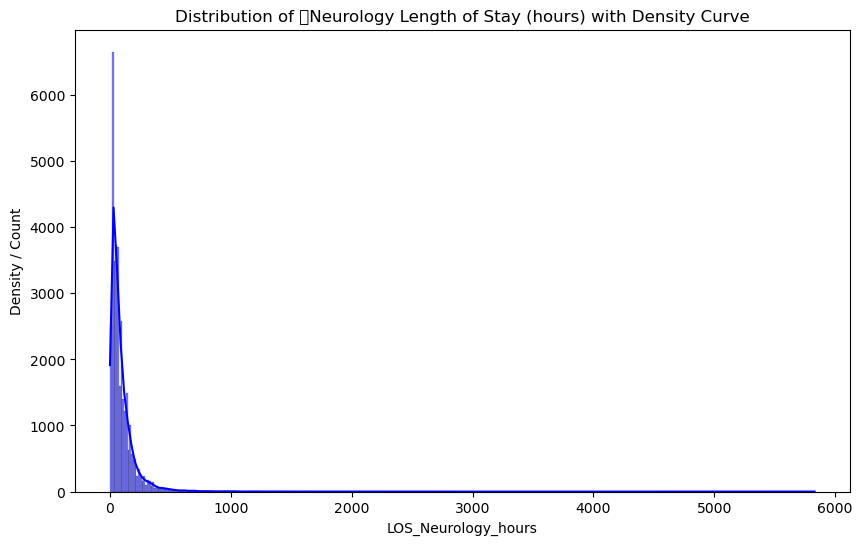

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.histplot(df_transfers['LOS_Neurology_hours'], bins=400, kde=True, color='blue')
plt.title('Distribution of 	Neurology Length of Stay (hours) with Density Curve')
plt.xlabel('LOS_Neurology_hours')
plt.ylabel('Density / Count')
plt.show()




In [91]:
df_transfers['LOS_Neurology_hours'].describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95, 0.99])


count    34290.000000
mean        93.980223
std        126.395860
min          0.000000
25%         26.660000
50%         63.135000
75%        116.960000
90%        194.863000
95%        283.030000
99%        532.689600
max       5829.860000
Name: LOS_Neurology_hours, dtype: float64

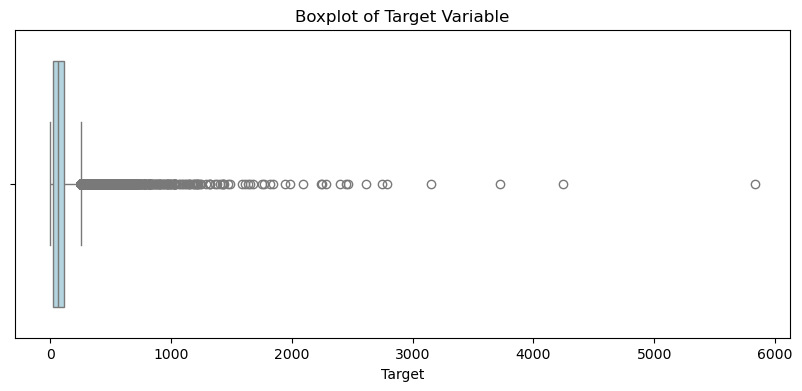

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.boxplot(x=df_transfers['LOS_Neurology_hours'], color='lightblue')
plt.title('Boxplot of Target Variable')
plt.xlabel('Target')
plt.show()


In [93]:
Q1 = df_transfers['LOS_Neurology_hours'].quantile(0.25)
Q3 = df_transfers['LOS_Neurology_hours'].quantile(0.75)
IQR = Q3 - Q1

upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR

outliers = df_transfers[(df_transfers['LOS_Neurology_hours'] > upper_limit) | (df_transfers['LOS_Neurology_hours'] < lower_limit)]
print(f"Outlier count: {len(outliers)} ({len(outliers)/len(df_transfers)*100:.2f}% of total)")


Outlier count: 2143 (6.25% of total)


In [94]:
upper_limit = df_transfers['LOS_Neurology_hours'].quantile(0.75) + 1.5 * (df_transfers['LOS_Neurology_hours'].quantile(0.75) - df_transfers['LOS_Neurology_hours'].quantile(0.25))
print("Upper limit (IQR method):", upper_limit)

df_transfers.loc[df_transfers['LOS_Neurology_hours'] > upper_limit, 'LOS_Neurology_hours'].describe()


Upper limit (IQR method): 252.40999999999997


count    2143.000000
mean      426.830098
std       300.365887
min       252.650000
25%       287.585000
50%       342.410000
75%       452.095000
max      5829.860000
Name: LOS_Neurology_hours, dtype: float64

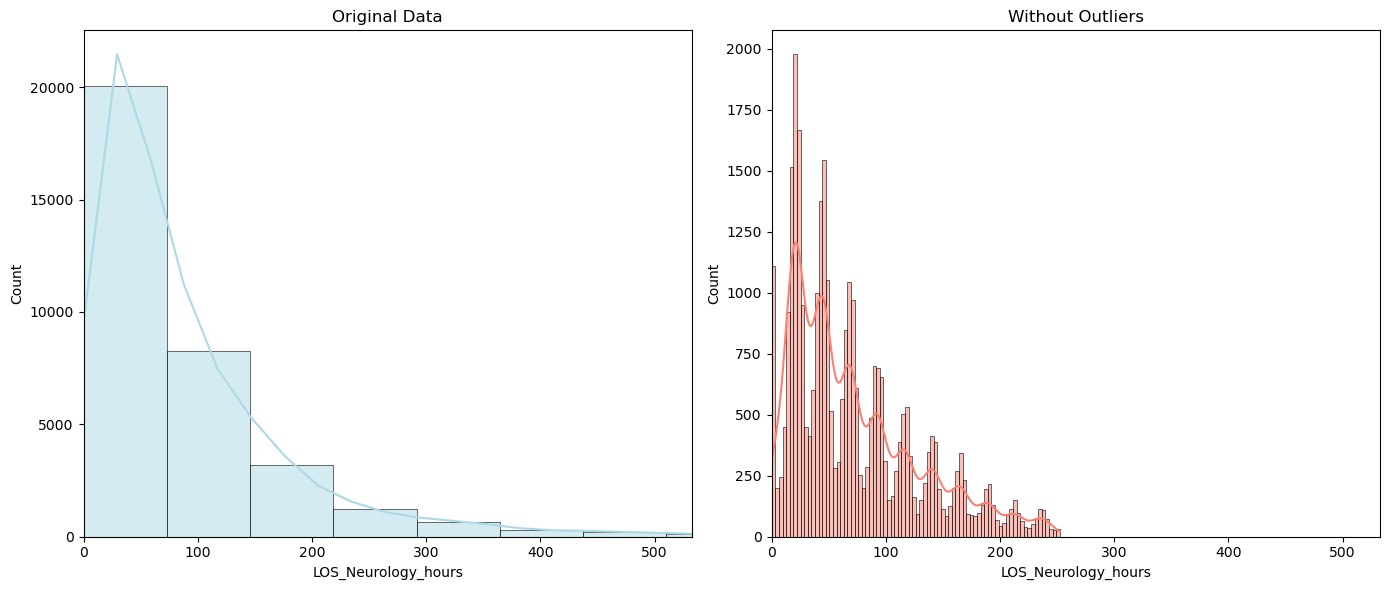

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Original
sns.histplot(df_transfers['LOS_Neurology_hours'], kde=True, bins=80, color='lightblue', stat='count', ax=axes[0])
axes[0].set_xlim(0, df_transfers['LOS_Neurology_hours'].quantile(0.99))
axes[0].set_title('Original Data')

# Without outliers
sns.histplot(df_transfers.loc[df_transfers['LOS_Neurology_hours'] <= upper_limit, 'LOS_Neurology_hours'], kde=True, bins=80, color='salmon', stat='count', ax=axes[1])
axes[1].set_xlim(0, df_transfers['LOS_Neurology_hours'].quantile(0.99))
axes[1].set_title('Without Outliers')

plt.tight_layout()
plt.show()


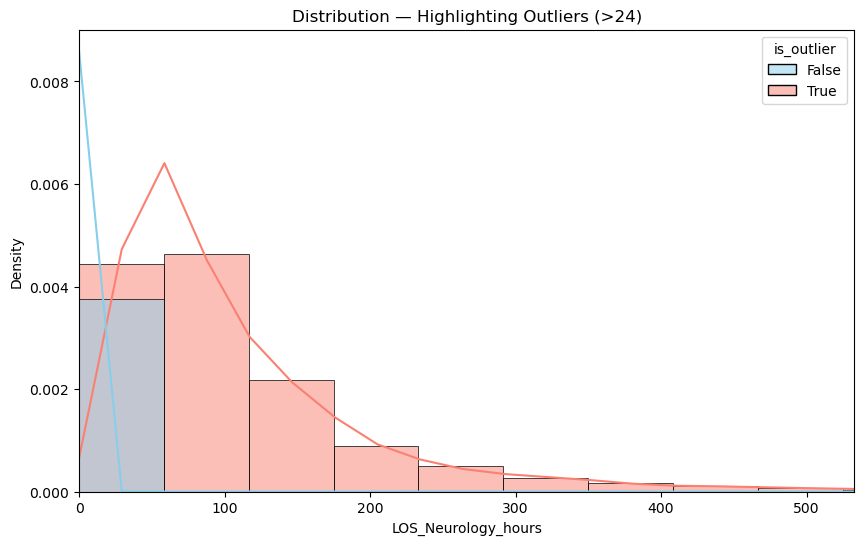

In [96]:
df_transfers['is_outlier'] = df_transfers['LOS_Neurology_hours'] > 24

plt.figure(figsize=(10,6))
sns.histplot(data=df_transfers, x='LOS_Neurology_hours', hue='is_outlier', bins=100, stat='density',
             palette={False: 'skyblue', True: 'salmon'}, kde=True)
plt.xlim(0, df_transfers['LOS_Neurology_hours'].quantile(0.99))
plt.title('Distribution — Highlighting Outliers (>24)')
plt.show()


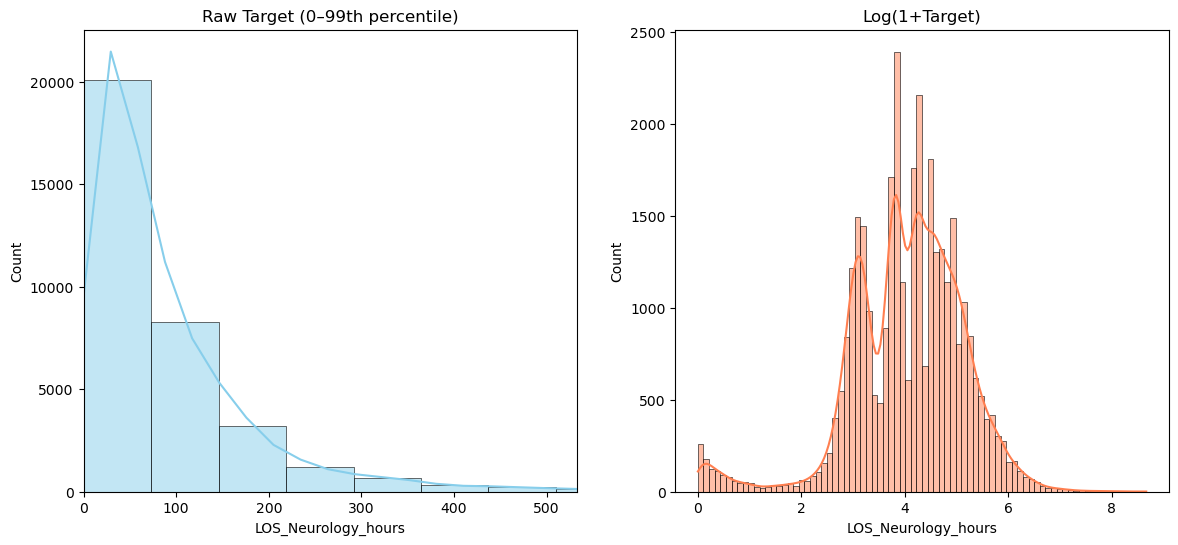

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.histplot(df_transfers['LOS_Neurology_hours'], kde=True, bins=80, stat='count', color='skyblue', ax=axes[0])
axes[0].set_xlim(0, df_transfers['LOS_Neurology_hours'].quantile(0.99))
axes[0].set_title('Raw Target (0–99th percentile)')

sns.histplot(np.log1p(df_transfers['LOS_Neurology_hours']), kde=True, bins=80, stat='count', color='coral', ax=axes[1])
axes[1].set_title('Log(1+Target)')

plt.show()


In [98]:
df_patients = pd.read_csv(r'C:\Users\arpitha_work\Downloads\TRU MSCDS\Sem 3\Graduate Project\MIMIC\mimic-iv-3.1\hosp\patients.csv')
df_patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364627 entries, 0 to 364626
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         364627 non-null  int64 
 1   gender             364627 non-null  object
 2   anchor_age         364627 non-null  int64 
 3   anchor_year        364627 non-null  int64 
 4   anchor_year_group  364627 non-null  object
 5   dod                38301 non-null   object
dtypes: int64(3), object(3)
memory usage: 16.7+ MB


In [99]:
df_patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000058,F,33,2168,2020 - 2022,NaN
3,10000068,F,19,2160,2008 - 2010,NaN
4,10000084,M,72,2160,2017 - 2019,2161-02-13


In [100]:
df_patients.isnull().sum()

subject_id                0
gender                    0
anchor_age                0
anchor_year               0
anchor_year_group         0
dod                  326326
dtype: int64

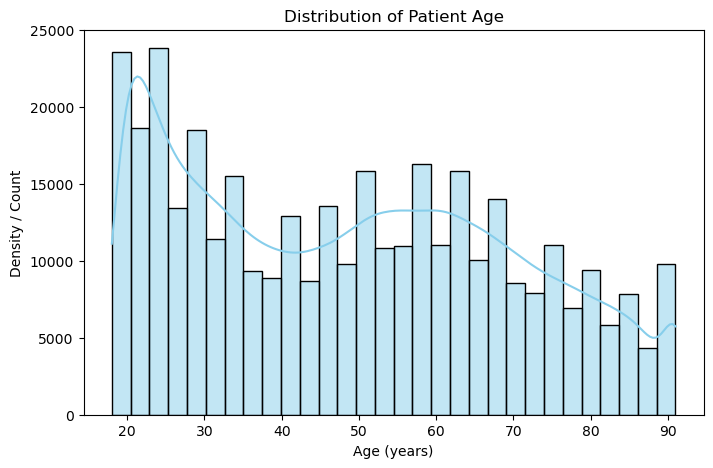

In [101]:
plt.figure(figsize=(8,5))
sns.histplot(df_patients['anchor_age'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Patient Age')
plt.xlabel('Age (years)')
plt.ylabel('Density / Count')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\3863528105.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=df_patients, palette='pastel')


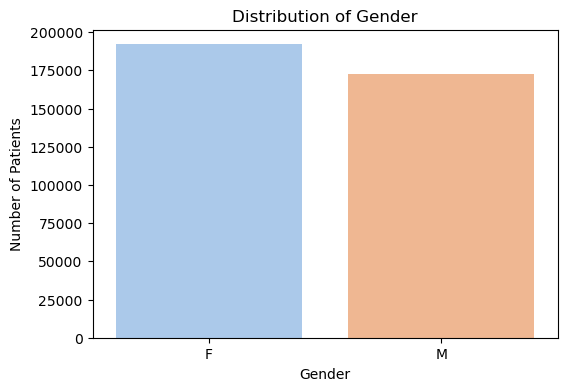

In [102]:
plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=df_patients, palette='pastel')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.show()


In [103]:
# lets keep only required columns in patients table
df_patients = df_patients.drop(columns=['anchor_year','anchor_year_group','dod'])

In [104]:
df_merge1=df_transfers.merge(df_patients,on='subject_id',how='left')
df_merge1.head()

,hadm_id,LOS_Neurology_hours,subject_id,is_outlier,gender,anchor_age
0,20000808.0,230.00,16788749,True,F,54
1,20002252.0,118.84,18826698,True,M,56
2,20002356.0,21.96,17488215,False,M,67
3,20002506.0,69.15,16230775,True,M,24
4,20002661.0,41.79,15497465,True,F,84


In [105]:
df_merge1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34290 entries, 0 to 34289
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hadm_id              34290 non-null  float64
 1   LOS_Neurology_hours  34290 non-null  float64
 2   subject_id           34290 non-null  int64  
 3   is_outlier           34290 non-null  bool   
 4   gender               34290 non-null  object 
 5   anchor_age           34290 non-null  int64  
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [106]:
df_merge1=df_merge1[df_merge1['anchor_age'] >=65]
df_merge1.head()

,hadm_id,LOS_Neurology_hours,subject_id,is_outlier,gender,anchor_age
2,20002356.0,21.96,17488215,False,M,67
4,20002661.0,41.79,15497465,True,F,84
6,20002970.0,95.92,11725083,True,F,75
7,20003425.0,19.12,12504470,False,M,76
9,20004165.0,41.20,16512642,True,F,76


In [107]:
df_merge1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14567 entries, 2 to 34289
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hadm_id              14567 non-null  float64
 1   LOS_Neurology_hours  14567 non-null  float64
 2   subject_id           14567 non-null  int64  
 3   is_outlier           14567 non-null  bool   
 4   gender               14567 non-null  object 
 5   anchor_age           14567 non-null  int64  
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 697.1+ KB


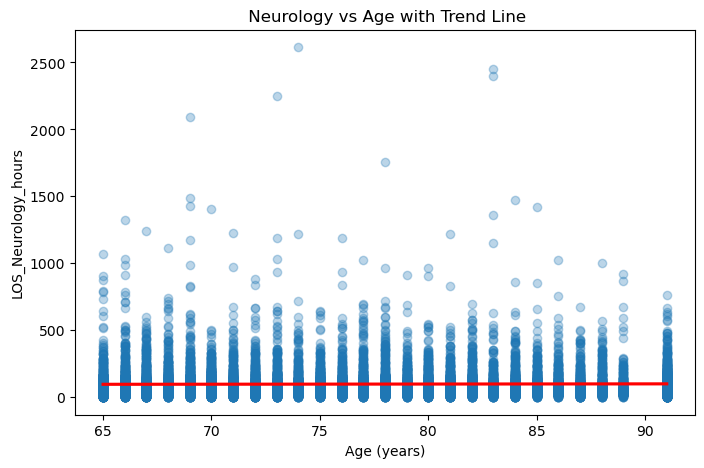

In [108]:
plt.figure(figsize=(8,5))
sns.regplot(x='anchor_age', y='LOS_Neurology_hours', data=df_merge1, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title(' Neurology vs Age with Trend Line')
plt.xlabel('Age (years)')
plt.ylabel('LOS_Neurology_hours')
plt.show()


In [109]:
corr = df_merge1['anchor_age'].corr(df_merge1['LOS_Neurology_hours'])
print(f"Correlation between age and Neurology LOS: {corr:.2f}")


Correlation between age and Neurology LOS: 0.01


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\4221433342.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='LOS_Neurology_hours', data=df_merge1, palette='viridis')


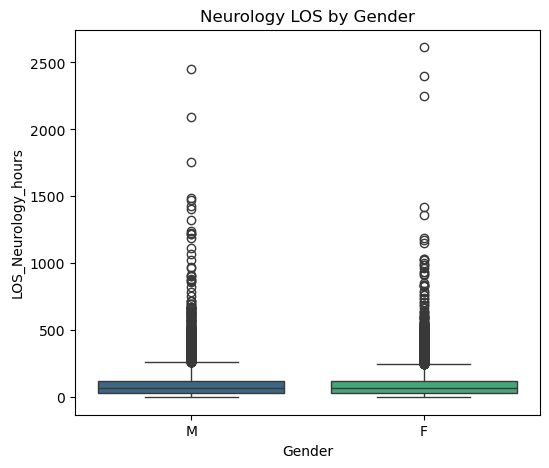

In [110]:
plt.figure(figsize=(6,5))
sns.boxplot(x='gender', y='LOS_Neurology_hours', data=df_merge1, palette='viridis')
plt.title('Neurology LOS by Gender')
plt.xlabel('Gender')
plt.ylabel('LOS_Neurology_hours')
plt.show()


In [111]:
df_admissions = pd.read_csv(r'C:\Users\arpitha_work\Downloads\TRU MSCDS\Sem 3\Graduate Project\MIMIC\mimic-iv-3.1\hosp\admissions.csv')
df_admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,English,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,English,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,English,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [112]:
df_admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546028 entries, 0 to 546027
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            546028 non-null  int64 
 1   hadm_id               546028 non-null  int64 
 2   admittime             546028 non-null  object
 3   dischtime             546028 non-null  object
 4   deathtime             11790 non-null   object
 5   admission_type        546028 non-null  object
 6   admit_provider_id     546024 non-null  object
 7   admission_location    546027 non-null  object
 8   discharge_location    396210 non-null  object
 9   insurance             536673 non-null  object
 10  language              545253 non-null  object
 11  marital_status        532409 non-null  object
 12  race                  546028 non-null  object
 13  edregtime             379240 non-null  object
 14  edouttime             379240 non-null  object
 15  hospital_expire_f

In [113]:
df_admissions = df_admissions.drop(columns=['dischtime','discharge_location','language',
                                            'edregtime','edouttime','hospital_expire_flag','deathtime'])

In [114]:
df_admissions = df_admissions.dropna(subset=['marital_status'])


In [115]:
df_admissions.isnull().sum()

subject_id               0
hadm_id                  0
admittime                0
admission_type           0
admit_provider_id        4
admission_location       0
insurance             8283
marital_status           0
race                     0
dtype: int64

In [116]:
df_admissions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532409 entries, 0 to 546026
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   subject_id          532409 non-null  int64 
 1   hadm_id             532409 non-null  int64 
 2   admittime           532409 non-null  object
 3   admission_type      532409 non-null  object
 4   admit_provider_id   532405 non-null  object
 5   admission_location  532409 non-null  object
 6   insurance           524126 non-null  object
 7   marital_status      532409 non-null  object
 8   race                532409 non-null  object
dtypes: int64(2), object(7)
memory usage: 40.6+ MB


In [117]:
#lets understand about provider

df_admissions['admit_provider_id'].nunique()

2038

In [118]:
patients_per_doctor = df_admissions.groupby('admit_provider_id')['subject_id'].nunique().reset_index()
patients_per_doctor.rename(columns={'subject_id': 'unique_patients'}, inplace=True)

print(patients_per_doctor)

     admit_provider_id  unique_patients
0               P00230                1
1               P004G6               20
2               P005Y0                1
3               P00628              214
4               P007EI              107
...                ...              ...
2033            P99GVJ              408
2034            P99MV4              421
2035            P99V46              201
2036            P99X3Q               42
2037            P99Z33               23

[2038 rows x 2 columns]


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\792934700.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='admission_type', data=df_admissions, palette='Set2')


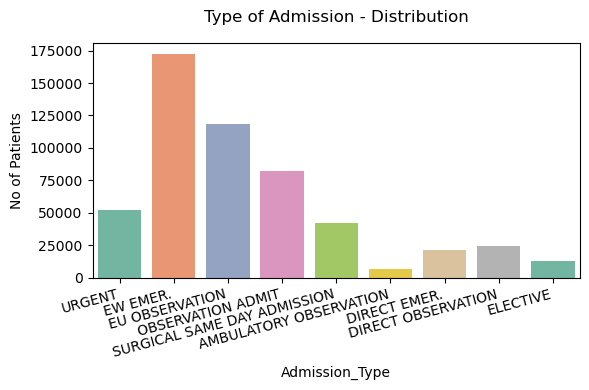

In [119]:
plt.figure(figsize=(6,4))
sns.countplot(x='admission_type', data=df_admissions, palette='Set2')
plt.title('Type of Admission - Distribution', pad=15)   
plt.xlabel('Admission_Type')
plt.ylabel('No of Patients')

# trying to rotate axis coz the titles were overlapping here
plt.xticks(rotation=15, ha='right') 
plt.tight_layout()
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\1013477000.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='admission_location', data=df_admissions, palette='Set2')


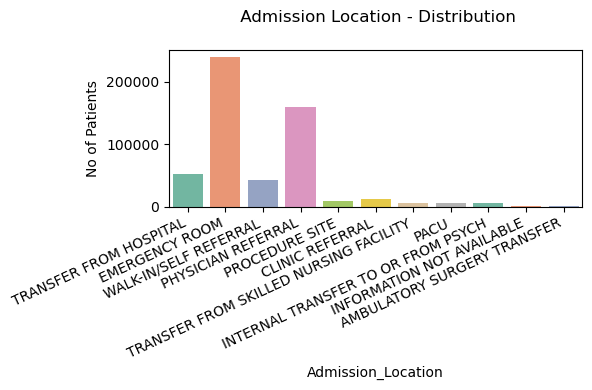

In [120]:
plt.figure(figsize=(6,4))
sns.countplot(x='admission_location', data=df_admissions, palette='Set2')
plt.title(' Admission Location - Distribution', pad=20)   
plt.xlabel('Admission_Location')
plt.ylabel('No of Patients')

# trying to rotate axis coz the titles were overlapping here
plt.xticks(rotation=25, ha='right') 
plt.tight_layout()
plt.show()


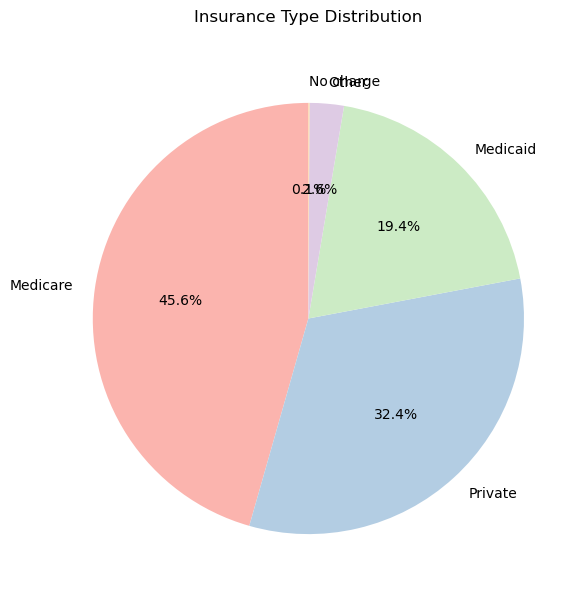

In [121]:
insurance_counts = df_admissions['insurance'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(
    insurance_counts, 
    labels=insurance_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.Pastel1.colors
)
plt.title('Insurance Type Distribution', pad=20)
plt.show()


In [122]:
df_merge2 = pd.merge(df_merge1, df_admissions, on=['hadm_id','subject_id'], how='inner')
#using inner here instead of left coz i need matching records from both tables.

In [123]:
df_merge2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13850 entries, 0 to 13849
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hadm_id              13850 non-null  float64
 1   LOS_Neurology_hours  13850 non-null  float64
 2   subject_id           13850 non-null  int64  
 3   is_outlier           13850 non-null  bool   
 4   gender               13850 non-null  object 
 5   anchor_age           13850 non-null  int64  
 6   admittime            13850 non-null  object 
 7   admission_type       13850 non-null  object 
 8   admit_provider_id    13850 non-null  object 
 9   admission_location   13850 non-null  object 
 10  insurance            13798 non-null  object 
 11  marital_status       13850 non-null  object 
 12  race                 13850 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 1.3+ MB


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\1813116702.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='insurance', x='LOS_Neurology_hours', data=df_merge2, palette='Set2')


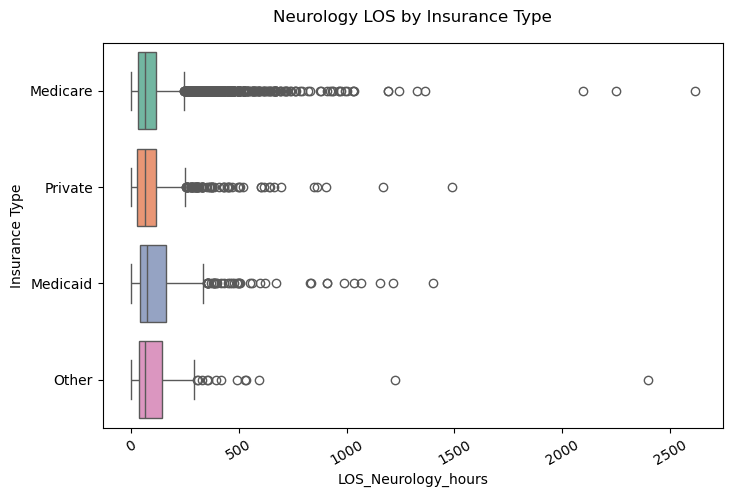

In [124]:
plt.figure(figsize=(8,5))
sns.boxplot(y='insurance', x='LOS_Neurology_hours', data=df_merge2, palette='Set2')
plt.title('Neurology LOS by Insurance Type', pad=15)
plt.xlabel('LOS_Neurology_hours')
plt.ylabel('Insurance Type')
plt.xticks(rotation=30)  # Rotate labels if too long
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\4029943536.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='admission_type', x='LOS_Neurology_hours', data=df_merge2, palette='Set2')


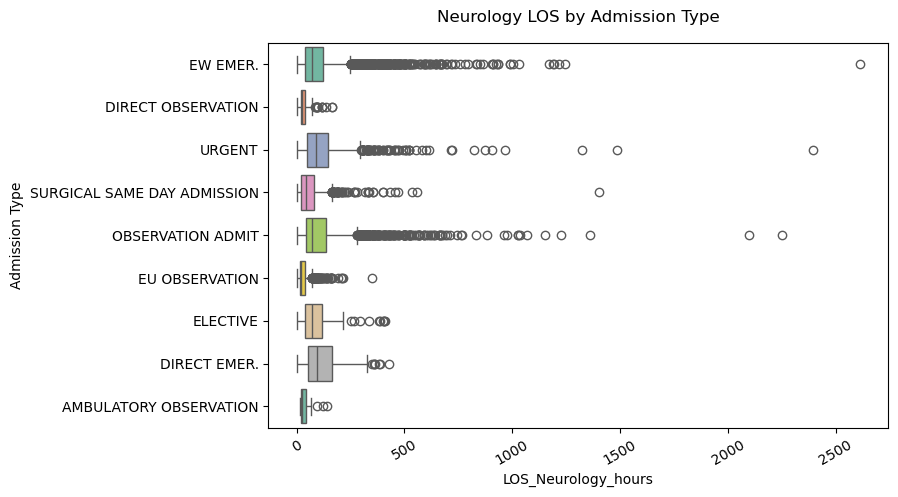

In [125]:
plt.figure(figsize=(8,5))
sns.boxplot(y='admission_type', x='LOS_Neurology_hours', data=df_merge2, palette='Set2')
plt.title('Neurology LOS by Admission Type', pad=15)
plt.xlabel('LOS_Neurology_hours')
plt.ylabel('Admission Type')
plt.xticks(rotation=30)  # Rotate labels if too long
plt.show()


In [126]:
df_merge2['LOS_Neurology_hours'].describe()

count    13850.000000
mean        95.738073
std        111.827232
min          0.000000
25%         32.350000
50%         66.740000
75%        118.727500
max       2613.660000
Name: LOS_Neurology_hours, dtype: float64

C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\3679392881.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


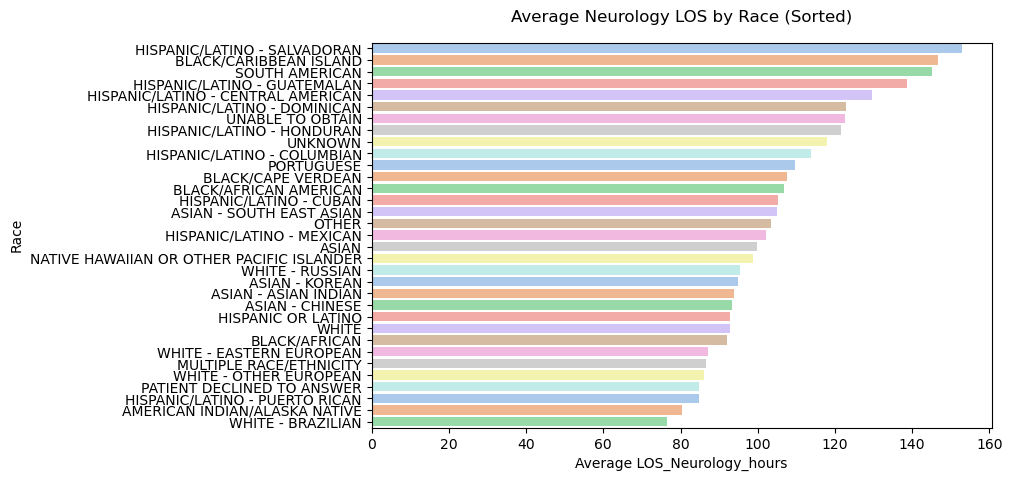

In [127]:
mean_los_race = df_merge2.groupby('race')['LOS_Neurology_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_Neurology_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='race', 
    x='LOS_Neurology_hours', 
    data=mean_los_race,
    palette='pastel'
)
plt.title('Average Neurology LOS by Race (Sorted)', pad=15)
plt.xlabel('Average LOS_Neurology_hours')
plt.ylabel('Race')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\1650677984.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


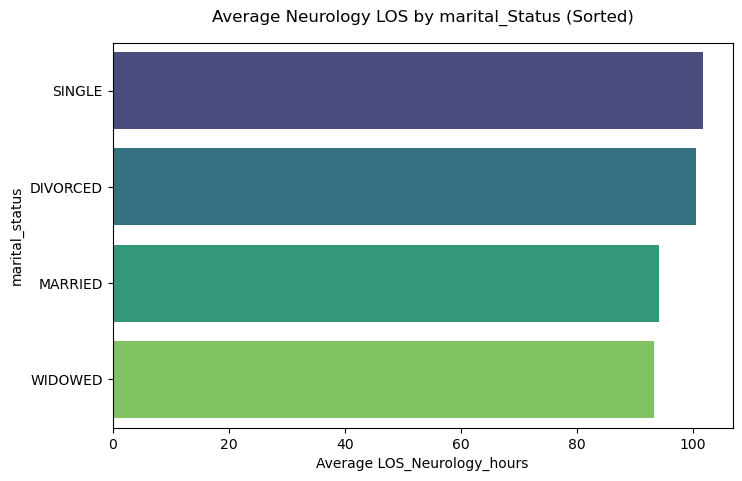

In [128]:
mean_los_race = df_merge2.groupby('marital_status')['LOS_Neurology_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_Neurology_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='marital_status', 
    x='LOS_Neurology_hours', 
    data=mean_los_race,
    palette='viridis'
)
plt.title('Average Neurology LOS by marital_Status (Sorted)', pad=15)
plt.xlabel('Average LOS_Neurology_hours')
plt.ylabel('marital_status')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\3391163109.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


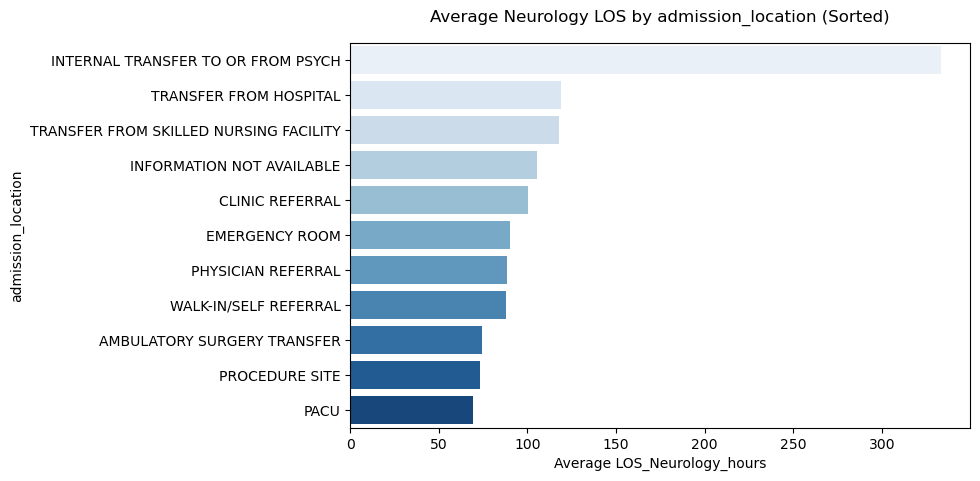

In [129]:
mean_los_race = df_merge2.groupby('admission_location')['LOS_Neurology_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_Neurology_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='admission_location', 
    x='LOS_Neurology_hours', 
    data=mean_los_race,
    palette='Blues'
)
plt.title('Average Neurology LOS by admission_location (Sorted)', pad=15)
plt.xlabel('Average LOS_Neurology_hours')
plt.ylabel('admission_location')
plt.show()


In [130]:
df_merge2 = pd.merge(df_merge1, df_admissions, on=['hadm_id','subject_id'], how='inner')
#using inner here instead of left coz i need matching records from both tables.

In [131]:
df_merge2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13850 entries, 0 to 13849
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hadm_id              13850 non-null  float64
 1   LOS_Neurology_hours  13850 non-null  float64
 2   subject_id           13850 non-null  int64  
 3   is_outlier           13850 non-null  bool   
 4   gender               13850 non-null  object 
 5   anchor_age           13850 non-null  int64  
 6   admittime            13850 non-null  object 
 7   admission_type       13850 non-null  object 
 8   admit_provider_id    13850 non-null  object 
 9   admission_location   13850 non-null  object 
 10  insurance            13798 non-null  object 
 11  marital_status       13850 non-null  object 
 12  race                 13850 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 1.3+ MB


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\3305903921.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='insurance', x='LOS_Neurology_hours', data=df_merge2, palette='Set2')


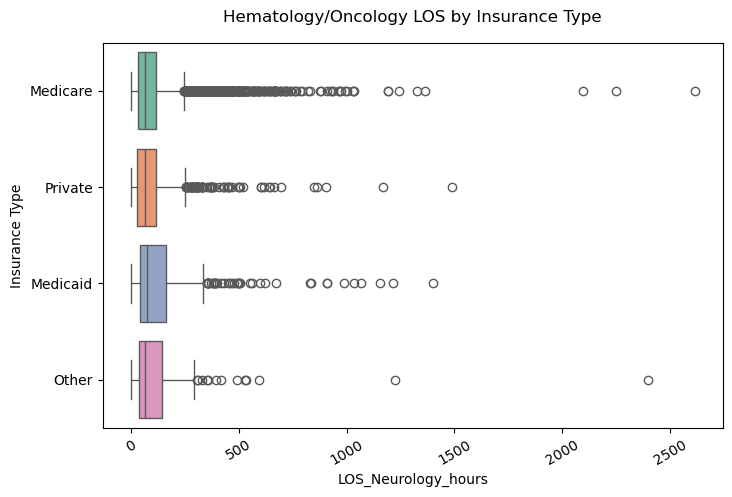

In [132]:
plt.figure(figsize=(8,5))
sns.boxplot(y='insurance', x='LOS_Neurology_hours', data=df_merge2, palette='Set2')
plt.title('Hematology/Oncology LOS by Insurance Type', pad=15)
plt.xlabel('LOS_Neurology_hours')
plt.ylabel('Insurance Type')
plt.xticks(rotation=30)  # Rotate labels if too long
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\4029943536.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='admission_type', x='LOS_Neurology_hours', data=df_merge2, palette='Set2')


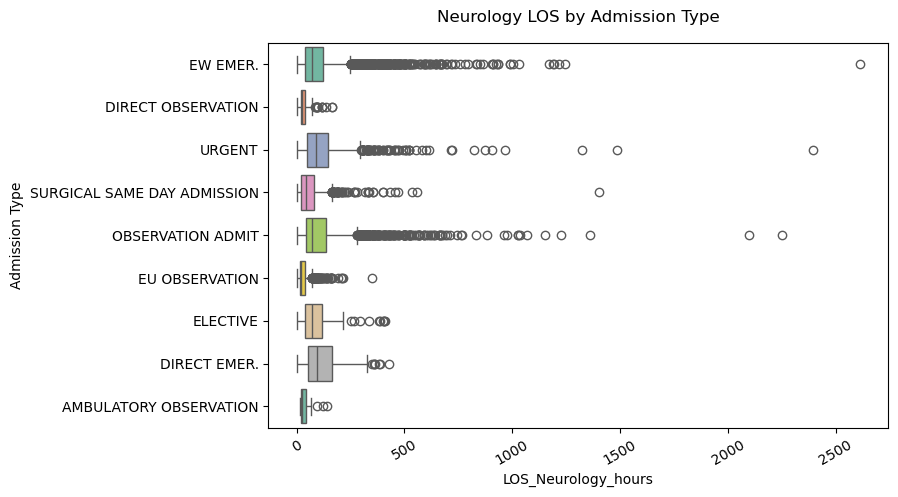

In [133]:
plt.figure(figsize=(8,5))
sns.boxplot(y='admission_type', x='LOS_Neurology_hours', data=df_merge2, palette='Set2')
plt.title('Neurology LOS by Admission Type', pad=15)
plt.xlabel('LOS_Neurology_hours')
plt.ylabel('Admission Type')
plt.xticks(rotation=30)  # Rotate labels if too long
plt.show()


In [134]:
df_merge2['LOS_Neurology_hours'].describe()

count    13850.000000
mean        95.738073
std        111.827232
min          0.000000
25%         32.350000
50%         66.740000
75%        118.727500
max       2613.660000
Name: LOS_Neurology_hours, dtype: float64

C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\3679392881.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


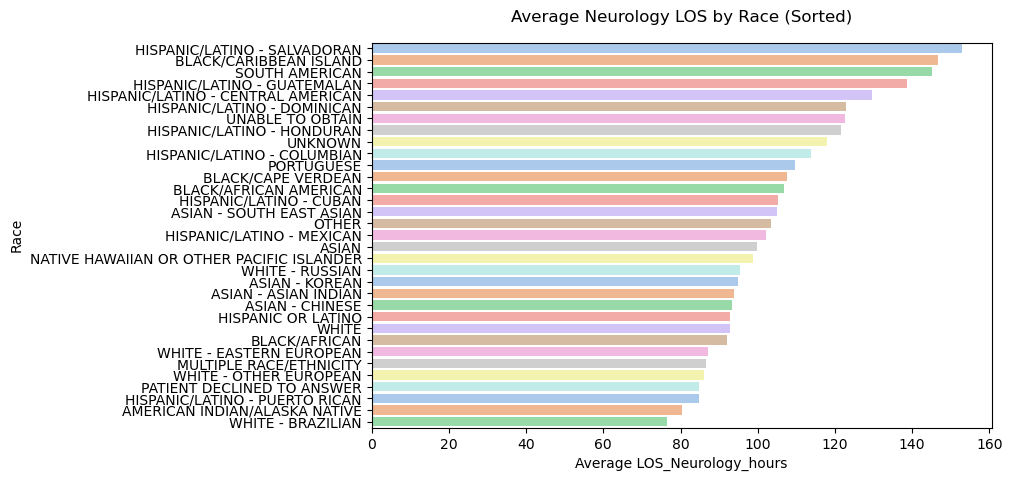

In [135]:
mean_los_race = df_merge2.groupby('race')['LOS_Neurology_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_Neurology_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='race', 
    x='LOS_Neurology_hours', 
    data=mean_los_race,
    palette='pastel'
)
plt.title('Average Neurology LOS by Race (Sorted)', pad=15)
plt.xlabel('Average LOS_Neurology_hours')
plt.ylabel('Race')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\1650677984.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


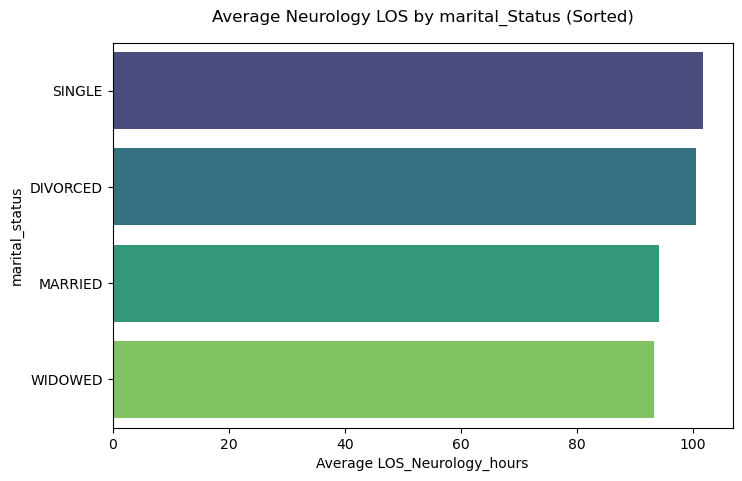

In [136]:
mean_los_race = df_merge2.groupby('marital_status')['LOS_Neurology_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_Neurology_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='marital_status', 
    x='LOS_Neurology_hours', 
    data=mean_los_race,
    palette='viridis'
)
plt.title('Average Neurology LOS by marital_Status (Sorted)', pad=15)
plt.xlabel('Average LOS_Neurology_hours')
plt.ylabel('marital_status')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\1469227970.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


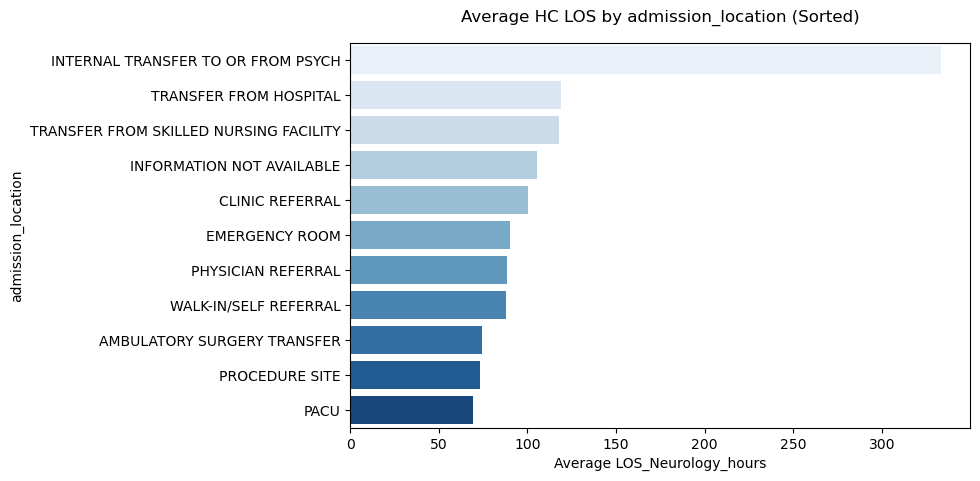

In [137]:
mean_los_race = df_merge2.groupby('admission_location')['LOS_Neurology_hours'].mean().reset_index()
mean_los_race = mean_los_race.sort_values(by='LOS_Neurology_hours', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    y='admission_location', 
    x='LOS_Neurology_hours', 
    data=mean_los_race,
    palette='Blues'
)
plt.title('Average HC LOS by admission_location (Sorted)', pad=15)
plt.xlabel('Average LOS_Neurology_hours')
plt.ylabel('admission_location')
plt.show()


In [138]:
df_merge2['admittime'] = pd.to_datetime(df_merge2['admittime'], errors='coerce')
df_merge2['admit_hour'] = df_merge2['admittime'].dt.hour
df_merge2['admit_day'] = df_merge2['admittime'].dt.dayofweek  # 0=Monday, 6=Sunday


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\83053143.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='admit_hour', y='LOS_Neurology_hours', data=df_merge2, palette='pastel')


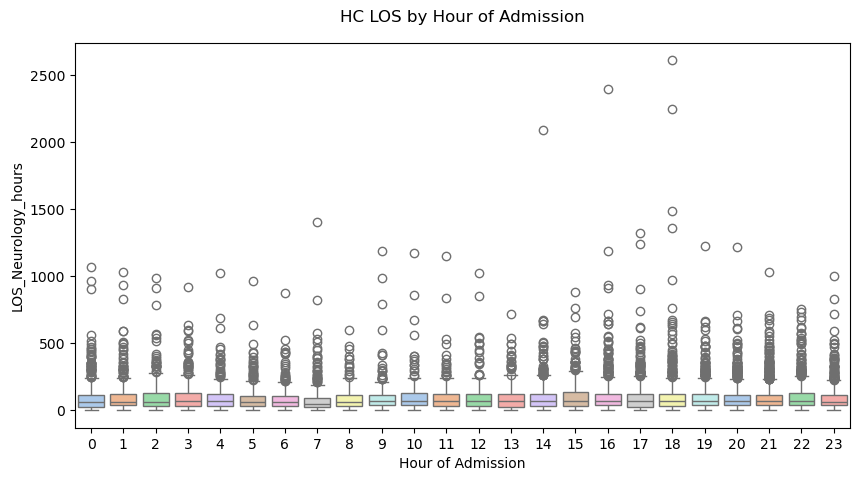

In [139]:
plt.figure(figsize=(10,5))
sns.boxplot(x='admit_hour', y='LOS_Neurology_hours', data=df_merge2, palette='pastel')
plt.title('HC LOS by Hour of Admission', pad=15)
plt.xlabel('Hour of Admission')
plt.ylabel('LOS_Neurology_hours')
plt.show()


C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\2395168876.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='admit_day', y='LOS_Neurology_hours', data=df_merge2, palette='Set2')


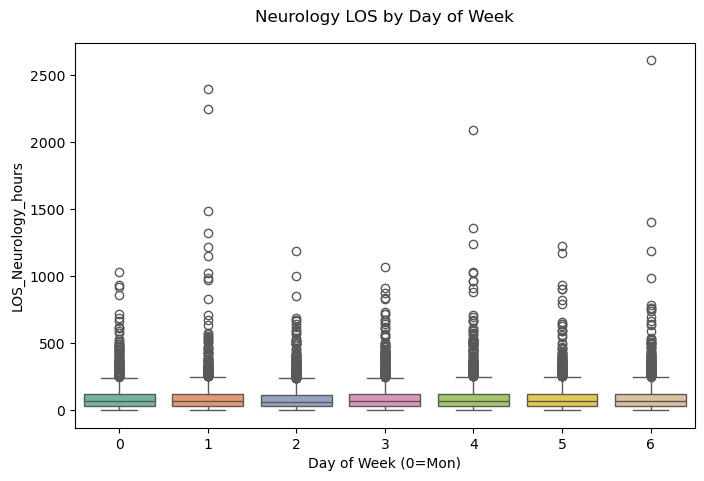

In [140]:
plt.figure(figsize=(8,5))
sns.boxplot(x='admit_day', y='LOS_Neurology_hours', data=df_merge2, palette='Set2')
plt.title('Neurology LOS by Day of Week', pad=15)
plt.xlabel('Day of Week (0=Mon)')
plt.ylabel('LOS_Neurology_hours')
plt.show()


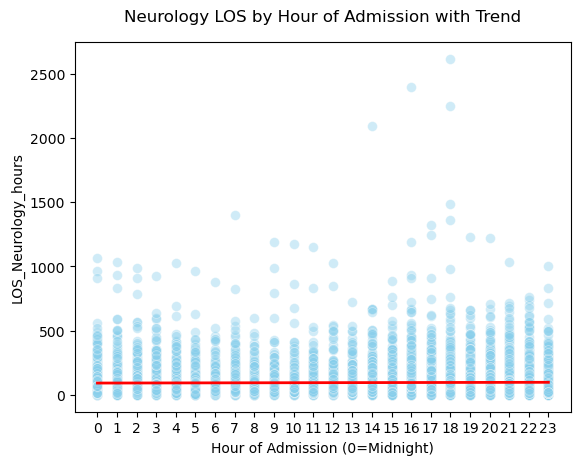

In [141]:
sns.scatterplot(
    x='admit_hour',
    y='LOS_Neurology_hours',
    data=df_merge2,
    color='skyblue',
    alpha=0.4,
    s=50
)

sns.regplot(
    x='admit_hour',
    y='LOS_Neurology_hours',
    data=df_merge2,
    scatter=False,          
    color='red',
    line_kws={'lw':2}
)

plt.title('Neurology LOS by Hour of Admission with Trend', pad=15)
plt.xlabel('Hour of Admission (0=Midnight)')
plt.ylabel('LOS_Neurology_hours')
plt.xticks(range(0,24))
plt.show()


In [142]:
file_path = r'C:\Users\arpitha_work\Downloads\TRU MSCDS\Sem 3\Graduate Project\MIMIC\mimic-iv-3.1\hosp\diagnoses_icd.csv.gz'
df_diagnoses = pd.read_csv(file_path, compression ='gzip')
df_diagnoses.head()


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [143]:
print('There are {} unique ICD9 codes in this dataset.'.format(df_diagnoses['icd_code'].value_counts().count()))

There are 28562 unique ICD9 codes in this dataset.


In [144]:
def categorize_icd9_short(code):
    """Return short ICD-9 category name"""
    if pd.isna(code):
        return 'misc'
    
    code_str = str(code).strip().upper()
    if code_str.startswith(('E', 'V')):
        return 'misc'  
    
    try:
        num = int(code_str[:3])
    except ValueError:
        return 'misc'
    
    ranges = [
        ((1, 139), 'infectious'),
        ((140, 239), 'neoplasms'),
        ((240, 279), 'endocrine'),
        ((280, 289), 'blood'),
        ((290, 319), 'mental'),
        ((320, 389), 'nervous'),
        ((390, 459), 'circulatory'),
        ((460, 519), 'respiratory'),
        ((520, 579), 'digestive'),
        ((580, 629), 'genitourinary'),
        ((630, 679), 'pregnancy'),
        ((680, 709), 'skin'),
        ((710, 739), 'muscular'),
        ((740, 759), 'congenital'),
        ((760, 779), 'prenatal'),
        ((780, 799), 'misc'),
        ((800, 999), 'injury')
    ]
    
    for (low, high), label in ranges:
        if low <= num <= high:
            return label
    return 'misc'

In [145]:
df_diagnoses['icd_category'] = df_diagnoses['icd_code'].apply(categorize_icd9_short)

diag_counts = (
    df_diagnoses.groupby(['hadm_id', 'icd_category'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

In [146]:
df_merge2 = df_merge2.merge(diag_counts, on='hadm_id', how='left')

In [147]:

df_merge2.fillna(0, inplace=True)

for col in diag_counts.columns:
    if col != 'hadm_id':
        df_merge2[col] = df_merge2[col].astype(int)


print(df_merge2.shape)
df_merge2.info()

(13850, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13850 entries, 0 to 13849
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   hadm_id              13850 non-null  float64       
 1   LOS_Neurology_hours  13850 non-null  float64       
 2   subject_id           13850 non-null  int64         
 3   is_outlier           13850 non-null  bool          
 4   gender               13850 non-null  object        
 5   anchor_age           13850 non-null  int64         
 6   admittime            13850 non-null  datetime64[ns]
 7   admission_type       13850 non-null  object        
 8   admit_provider_id    13850 non-null  object        
 9   admission_location   13850 non-null  object        
 10  insurance            13850 non-null  object        
 11  marital_status       13850 non-null  object        
 12  race                 13850 non-null  object        
 13  admit_hour         

In [148]:
df_merge2.head()

,hadm_id,LOS_Neurology_hours,subject_id,is_outlier,gender,anchor_age,admittime,admission_type,admit_provider_id,admission_location,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,20002356.0,21.96,17488215,False,M,67,2166-10-04 20:02:00,EW EMER.,P78P8W,EMERGENCY ROOM,...,0,0,1,0,0,0,0,0,0,0
1,20002661.0,41.79,15497465,True,F,84,2171-05-09 11:45:00,DIRECT OBSERVATION,P61CDO,PHYSICIAN REFERRAL,...,0,0,15,0,0,0,0,0,0,0
2,20003425.0,19.12,12504470,False,M,76,2155-07-21 10:00:00,URGENT,P968HV,TRANSFER FROM SKILLED NURSING FACILITY,...,0,0,26,0,0,0,0,0,0,0
3,20004165.0,41.20,16512642,True,F,76,2116-07-21 00:00:00,SURGICAL SAME DAY ADMISSION,P64UQ5,PHYSICIAN REFERRAL,...,0,0,15,0,0,0,0,0,0,0
4,20004287.0,65.74,19823198,True,F,66,2171-04-20 21:44:00,OBSERVATION ADMIT,P20PIB,TRANSFER FROM HOSPITAL,...,0,0,8,0,0,0,0,0,0,0


In [149]:
diseases = [
    'blood', 'circulatory', 'congenital', 'digestive', 'endocrine',
    'genitourinary', 'infectious', 'injury', 'mental', 'misc',
    'muscular', 'neoplasms', 'nervous', 'respiratory', 'skin'
]

mean_los = {}
for disease in diseases:
    mean_los[disease] = df_merge2.loc[df_merge2[disease] > 0, 'LOS_Neurology_hours'].mean()

C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\2870609605.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=list(mean_los.keys()), y=list(mean_los.values()), palette='viridis')


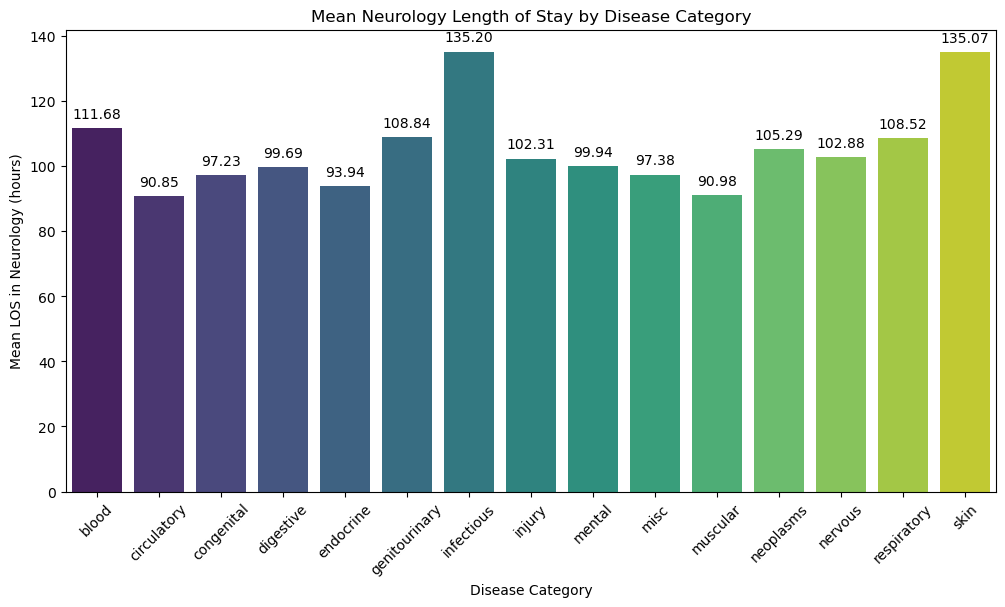

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
bars = sns.barplot(x=list(mean_los.keys()), y=list(mean_los.values()), palette='viridis')


for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{height:.2f}',  # 2 decimal places
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),  
                  textcoords='offset points',
                  ha='center', va='bottom')

plt.xticks(rotation=45)
plt.ylabel('Mean LOS in Neurology (hours)')
plt.xlabel('Disease Category')
plt.title('Mean Neurology Length of Stay by Disease Category')
plt.show()


In [151]:
df_merge2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13850 entries, 0 to 13849
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   hadm_id              13850 non-null  float64       
 1   LOS_Neurology_hours  13850 non-null  float64       
 2   subject_id           13850 non-null  int64         
 3   is_outlier           13850 non-null  bool          
 4   gender               13850 non-null  object        
 5   anchor_age           13850 non-null  int64         
 6   admittime            13850 non-null  datetime64[ns]
 7   admission_type       13850 non-null  object        
 8   admit_provider_id    13850 non-null  object        
 9   admission_location   13850 non-null  object        
 10  insurance            13850 non-null  object        
 11  marital_status       13850 non-null  object        
 12  race                 13850 non-null  object        
 13  admit_hour           13850 non-

In [152]:
df_merge2.head()

,hadm_id,LOS_Neurology_hours,subject_id,is_outlier,gender,anchor_age,admittime,admission_type,admit_provider_id,admission_location,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,20002356.0,21.96,17488215,False,M,67,2166-10-04 20:02:00,EW EMER.,P78P8W,EMERGENCY ROOM,...,0,0,1,0,0,0,0,0,0,0
1,20002661.0,41.79,15497465,True,F,84,2171-05-09 11:45:00,DIRECT OBSERVATION,P61CDO,PHYSICIAN REFERRAL,...,0,0,15,0,0,0,0,0,0,0
2,20003425.0,19.12,12504470,False,M,76,2155-07-21 10:00:00,URGENT,P968HV,TRANSFER FROM SKILLED NURSING FACILITY,...,0,0,26,0,0,0,0,0,0,0
3,20004165.0,41.20,16512642,True,F,76,2116-07-21 00:00:00,SURGICAL SAME DAY ADMISSION,P64UQ5,PHYSICIAN REFERRAL,...,0,0,15,0,0,0,0,0,0,0
4,20004287.0,65.74,19823198,True,F,66,2171-04-20 21:44:00,OBSERVATION ADMIT,P20PIB,TRANSFER FROM HOSPITAL,...,0,0,8,0,0,0,0,0,0,0


In [153]:
#model

In [154]:
neuro_hadm_ids = set(df_merge2["hadm_id"].dropna().unique())
print("Neurology admissions:", len(neuro_hadm_ids))


Neurology admissions: 13850


In [155]:
DLABITEMS_PATH = r"C:\Users\arpitha_work\Downloads\TRU MSCDS\Sem 3\Graduate Project\MIMIC\mimic-iv-3.1\hosp\d_labitems.csv"

df_labitems = pd.read_csv(
    DLABITEMS_PATH,
    #compression="gzip",
    usecols=["itemid", "label"]
)


NEURO_LABS = {
    "Sodium",
    "Creatinine",
    #"White Blood Cells",
    #"Glucose"
}

neuro_labitems = df_labitems[df_labitems["label"].isin(NEURO_LABS)].copy()
neuro_lab_itemids = set(neuro_labitems["itemid"].unique())

print("Selected Neuro lab itemids:", neuro_lab_itemids)


Selected Neuro lab itemids: {np.int64(50912), np.int64(52546), np.int64(52623), np.int64(50983)}


In [156]:
adm_time_map = (
    df_admissions[["hadm_id", "admittime"]]
    .assign(admittime=lambda x: pd.to_datetime(x["admittime"], errors="coerce"))
    .set_index("hadm_id")["admittime"]
    .to_dict()
)


In [157]:
neuro_lab_itemids = set(neuro_labitems["itemid"].unique())

print("ItemIDs to keep:", neuro_lab_itemids)


ItemIDs to keep: {np.int64(50912), np.int64(52546), np.int64(52623), np.int64(50983)}


In [158]:
import time
import numpy as np
import pandas as pd
from collections import defaultdict


LABEVENTS_PATH = r"C:\Users\arpitha_work\Downloads\TRU MSCDS\Sem 3\Graduate Project\MIMIC\mimic-iv-3.1\hosp\labevents.csv.gz"


EARLY_WINDOW_HOURS = 6
CHUNKSIZE = 50_000

t0 = time.time()
chunk_counter = 0
rows_kept_total = 0

sum_dict   = defaultdict(float)
count_dict = defaultdict(int)
min_dict   = defaultdict(lambda: np.inf)
max_dict   = defaultdict(lambda: -np.inf)

for chunk in pd.read_csv(
    LABEVENTS_PATH,
    compression="gzip",
    usecols=["hadm_id", "itemid", "charttime", "valuenum"],
    chunksize=CHUNKSIZE
):
    chunk_counter += 1

   
    chunk = chunk[
        chunk["hadm_id"].isin(neuro_hadm_ids) &
        chunk["itemid"].isin(neuro_lab_itemids)
    ].dropna(subset=["charttime", "valuenum"])

    if chunk.empty:
        if chunk_counter % 50 == 0:
            print(f"chunks={chunk_counter}, kept_rows={rows_kept_total}, elapsed={(time.time()-t0)/60:.1f} min")
        continue

    chunk["charttime"] = pd.to_datetime(chunk["charttime"], errors="coerce")
    chunk = chunk.dropna(subset=["charttime"])

    
    chunk["admittime"] = chunk["hadm_id"].map(adm_time_map)
    chunk = chunk.dropna(subset=["admittime"])

    hours_from_admit = (
        (chunk["charttime"] - chunk["admittime"])
        .dt.total_seconds() / 3600.0
    )

    chunk = chunk[(hours_from_admit >= 0) & (hours_from_admit <= EARLY_WINDOW_HOURS)]

    if chunk.empty:
        if chunk_counter % 50 == 0:
            print(f"chunks={chunk_counter}, kept_rows={rows_kept_total}, elapsed={(time.time()-t0)/60:.1f} min")
        continue

    rows_kept_total += len(chunk)

    
    g = chunk.groupby(["hadm_id", "itemid"])["valuenum"]
    s = g.sum()
    c = g.count()
    mn = g.min()
    mx = g.max()

    for k, v in s.items():
        sum_dict[k] += float(v)
    for k, v in c.items():
        count_dict[k] += int(v)
    for k, v in mn.items():
        min_dict[k] = min(min_dict[k], float(v))
    for k, v in mx.items():
        max_dict[k] = max(max_dict[k], float(v))

    if chunk_counter % 50 == 0:
        print(f"chunks={chunk_counter}, kept_rows={rows_kept_total}, elapsed={(time.time()-t0)/60:.1f} min")

print(" Finished streaming labevents")
print("Total chunks:", chunk_counter)
print("Rows kept:", rows_kept_total)
print("Total minutes:", (time.time() - t0) / 60)


chunks=50, kept_rows=115, elapsed=0.6 min
chunks=100, kept_rows=227, elapsed=1.6 min
chunks=150, kept_rows=360, elapsed=2.2 min
chunks=200, kept_rows=492, elapsed=2.8 min
chunks=250, kept_rows=629, elapsed=3.3 min
chunks=300, kept_rows=749, elapsed=3.9 min
chunks=350, kept_rows=899, elapsed=4.4 min
chunks=400, kept_rows=1040, elapsed=5.0 min
chunks=450, kept_rows=1170, elapsed=5.6 min
chunks=500, kept_rows=1305, elapsed=6.5 min
chunks=550, kept_rows=1471, elapsed=7.3 min
chunks=600, kept_rows=1588, elapsed=8.2 min
chunks=650, kept_rows=1722, elapsed=9.1 min
chunks=700, kept_rows=1857, elapsed=9.9 min
chunks=750, kept_rows=1986, elapsed=10.7 min
chunks=800, kept_rows=2119, elapsed=11.5 min
chunks=850, kept_rows=2252, elapsed=12.2 min
chunks=900, kept_rows=2387, elapsed=12.7 min
chunks=950, kept_rows=2532, elapsed=13.3 min
chunks=1000, kept_rows=2666, elapsed=13.9 min
chunks=1050, kept_rows=2797, elapsed=14.5 min
chunks=1100, kept_rows=2918, elapsed=15.1 min
chunks=1150, kept_rows=3085, 

C:\Users\arpitha_work\AppData\Local\Temp\ipykernel_13496\546789425.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk["charttime"] = pd.to_datetime(chunk["charttime"], errors="coerce")


chunks=3100, kept_rows=8006, elapsed=48.3 min
chunks=3150, kept_rows=8118, elapsed=49.2 min
 Finished streaming labevents
Total chunks: 3168
Rows kept: 8150
Total minutes: 49.45697195927302


In [159]:

rows = []
for (hadm_id, itemid), cnt in count_dict.items():
    rows.append({
        "hadm_id": hadm_id,
        "itemid": itemid,
        "lab_mean": sum_dict[(hadm_id, itemid)] / cnt,
        "lab_min":  min_dict[(hadm_id, itemid)],
        "lab_max":  max_dict[(hadm_id, itemid)],
        "lab_count": cnt
    })

lab_agg = pd.DataFrame(rows)


lab_agg = lab_agg.merge(df_labitems, on="itemid", how="left")

print("\nLab long table:", lab_agg.shape)
print(lab_agg.head())


lab_agg.to_csv("neuro_lab_agg_long.csv", index=False)
print("Saved: neuro_lab_agg_long.csv")




Lab long table: (7950, 7)
      hadm_id  itemid  lab_mean  lab_min  lab_max  lab_count       label
0  21364145.0   50912       2.6      2.6      2.6          1  Creatinine
1  21364145.0   50983     141.0    141.0    141.0          1      Sodium
2  26948481.0   50912       0.4      0.4      0.4          1  Creatinine
3  26948481.0   50983     142.0    142.0    142.0          1      Sodium
4  22014575.0   50912       1.0      1.0      1.0          1  Creatinine
Saved: neuro_lab_agg_long.csv


In [160]:

lab_agg["lab_sum"] = lab_agg["lab_mean"] * lab_agg["lab_count"]

lab_collapsed = (
    lab_agg
    .groupby(["hadm_id", "label"], as_index=False)
    .agg(
        lab_sum=("lab_sum", "sum"),
        lab_count=("lab_count", "sum"),
        lab_min=("lab_min", "min"),
        lab_max=("lab_max", "max")
    )
)

lab_collapsed["lab_mean"] = lab_collapsed["lab_sum"] / lab_collapsed["lab_count"]

print("\nCollapsed lab table:", lab_collapsed.shape)
print("Duplicates remaining?",
      lab_collapsed.duplicated(subset=["hadm_id", "label"]).any())



Collapsed lab table: (7950, 7)
Duplicates remaining? False


In [161]:

lab_wide = lab_collapsed.pivot_table(
    index="hadm_id",
    columns="label",
    values=["lab_mean", "lab_min", "lab_max", "lab_count"],
    aggfunc="first"
)

lab_wide.columns = [f"{stat}_{label}".replace(" ", "_") for stat, label in lab_wide.columns]
lab_wide = lab_wide.reset_index()

print("\nLab wide features:", lab_wide.shape)
print(lab_wide.head())


Lab wide features: (4018, 9)
      hadm_id  lab_count_Creatinine  lab_count_Sodium  lab_max_Creatinine  \
0  20004387.0                   1.0               1.0                 0.8   
1  20005426.0                   1.0               1.0                 0.6   
2  20010031.0                   1.0               1.0                 0.7   
3  20011117.0                   1.0               1.0                 1.0   
4  20012830.0                   1.0               1.0                 1.2   

   lab_max_Sodium  lab_mean_Creatinine  lab_mean_Sodium  lab_min_Creatinine  \
0           134.0                  0.8            134.0                 0.8   
1           135.0                  0.6            135.0                 0.6   
2           137.0                  0.7            137.0                 0.7   
3           141.0                  1.0            141.0                 1.0   
4           144.0                  1.2            144.0                 1.2   

   lab_min_Sodium  
0           

In [162]:


df_merge2 = df_merge2.merge(lab_wide, on="hadm_id", how="left")
print("\n✅ df_merge2 shape after merging labs:", df_merge2.shape)



✅ df_merge2 shape after merging labs: (13850, 40)


In [163]:
import numpy as np
import pandas as pd



df_diag = df_diagnoses[["hadm_id", "icd_code", "icd_version"]].copy()

def normalize_icd(code):
    if pd.isna(code):
        return ""
    return str(code).strip().upper().replace(".", "")

df_diag["icd_code_clean"] = df_diag["icd_code"].apply(normalize_icd)
df_diag["is_icd10"] = (df_diag["icd_version"] == 10)

def icd3(row):
    c = row["icd_code_clean"]
    if c == "":
        return ""
    if row["is_icd10"]:
        return c[:3]  # ICD-10 prefix like I63, G40, S06
    # ICD-9 numeric first 3 digits
    digits = "".join(ch for ch in c if ch.isdigit())
    return digits[:3] if len(digits) >= 3 else digits

df_diag["icd3"] = df_diag.apply(icd3, axis=1)


In [164]:

diag_complex = (
    df_diag.groupby("hadm_id")
    .agg(
        n_icd_codes=("icd_code_clean", "count"),
        n_unique_icd3=("icd3", lambda x: x.nunique())
    )
    .reset_index()
)


ICD10_PREFIX = {
    "has_stroke": {"I63", "I64"},
    "has_hemorrhage": {"I60", "I61", "I62"},
    "has_seizure": {"G40"},
    "has_head_injury": {"S06"},
    "has_neurodegenerative": {"G20", "G30"},
    "has_brain_tumor": {"C71", "D33"},
    "has_migraine": {"G43"},
}

ICD9_RANGES = {
    "has_stroke": [(430, 438)],
    "has_hemorrhage": [(430, 432)],
    "has_seizure": [(345, 345)],
    "has_head_injury": [(850, 854)],
    "has_neurodegenerative": [(331, 331), (332, 332)],
    "has_brain_tumor": [(191, 191), (225, 225)],
    "has_migraine": [(346, 346)],
}

def flag_icd10(icd3_list, prefixes):
    return int(any(str(v) in prefixes for v in icd3_list if str(v)))

def flag_icd9(icd3_list, ranges):
    nums = [int(v) for v in icd3_list if str(v).isdigit()]
    for lo, hi in ranges:
        if any(lo <= n <= hi for n in nums):
            return 1
    return 0

flags_rows = []
for hadm_id, g in df_diag.groupby("hadm_id"):
    icd3_list = g["icd3"].dropna().tolist()
    out = {"hadm_id": hadm_id}

    # ICD-10 flags
    for feat, prefset in ICD10_PREFIX.items():
        out[feat] = flag_icd10(icd3_list, prefset)

    # ICD-9 flags (take max with ICD-10)
    for feat, ranges in ICD9_RANGES.items():
        out[feat] = max(out.get(feat, 0), flag_icd9(icd3_list, ranges))

    flags_rows.append(out)

diag_flags = pd.DataFrame(flags_rows)



In [165]:

df_merge2 = df_merge2.merge(diag_complex, on="hadm_id", how="left")
df_merge2 = df_merge2.merge(diag_flags, on="hadm_id", how="left")


new_cols = ["n_icd_codes", "n_unique_icd3"] + list(ICD10_PREFIX.keys())
for c in new_cols:
    if c in df_merge2.columns:
        df_merge2[c] = df_merge2[c].fillna(0).astype(float)

print("✅ Block 1 upgrade added columns:", new_cols)
print("df_merge2 shape:", df_merge2.shape)

✅ Block 1 upgrade added columns: ['n_icd_codes', 'n_unique_icd3', 'has_stroke', 'has_hemorrhage', 'has_seizure', 'has_head_injury', 'has_neurodegenerative', 'has_brain_tumor', 'has_migraine']
df_merge2 shape: (13850, 49)


In [166]:
import numpy as np
import pandas as pd


adm = df_admissions[[
    "hadm_id",
    "subject_id",
    "admittime"
]].copy()


adm["admittime"] = pd.to_datetime(adm["admittime"], errors="coerce")


adm = adm.sort_values(["subject_id", "admittime"]).copy()


adm["prev_adm_count"] = adm.groupby("subject_id").cumcount()


adm["prev_admittime"] = adm.groupby("subject_id")["admittime"].shift(1)
adm["days_since_last_adm"] = (
    adm["admittime"] - adm["prev_admittime"]
).dt.total_seconds() / (3600 * 24)


hist_feats = adm[[
    "hadm_id",
    "prev_adm_count",
    "days_since_last_adm"
]].copy()


df_merge2 = df_merge2.merge(hist_feats, on="hadm_id", how="left")


df_merge2["prev_adm_count"] = df_merge2["prev_adm_count"].fillna(0).astype(float)


df_merge2["days_since_last_adm"] = df_merge2["days_since_last_adm"].fillna(-1).astype(float)

print("BLOCK 2 (no dischtime) added:")
print(df_merge2[["prev_adm_count", "days_since_last_adm"]].describe())
print("df_merge2 shape:", df_merge2.shape)


BLOCK 2 (no dischtime) added:
       prev_adm_count  days_since_last_adm
count    13850.000000         13850.000000
mean         1.475812           203.260699
std          3.435094           517.284138
min          0.000000            -1.000000
25%          0.000000            -1.000000
50%          0.000000            -1.000000
75%          2.000000           100.962500
max        101.000000          5161.906250
df_merge2 shape: (13850, 51)


In [167]:
# TARGET_COL = "LOS_Neurology_hours"


# df_merge2 = df_merge2.copy()


# df_merge2 = df_merge2[df_merge2[TARGET_COL].notna()].copy()
# df_merge2 = df_merge2[df_merge2[TARGET_COL] > 0].copy()


# cap_99 = df_merge2[TARGET_COL].quantile(0.99)
# df_merge2["los_capped"] = df_merge2[TARGET_COL].clip(upper=cap_99)


# df_merge2["los_log"] = np.log1p(df_merge2["los_capped"])

# print("HC rows after cleaning:", len(df_merge2))
# print("HC 99th percentile cap (hours):", cap_99)
# print(df_merge2[[TARGET_COL, "los_capped", "los_log"]].describe())


In [168]:
TARGET_COL = "LOS_Neurology_hours"

df_merge2 = df_merge2[df_merge2[TARGET_COL].notna()].copy()
df_merge2 = df_merge2[df_merge2[TARGET_COL] > 0].copy()

# ---- Choose bins (3-class example) ----
bins = [0, 48, 168, np.inf]
labels = [0, 1, 2]  # 0=short, 1=medium, 2=long

df_merge2["los_class"] = pd.cut(df_merge2[TARGET_COL], bins=bins, labels=labels, right=False)
df_merge2 = df_merge2[df_merge2["los_class"].notna()].copy()
df_merge2["los_class"] = df_merge2["los_class"].astype(int)

print(df_merge2["los_class"].value_counts(normalize=True).sort_index())


los_class
0    0.397500
1    0.465207
2    0.137293
Name: proportion, dtype: float64


In [169]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# X = df_merge2.drop(columns=["LOS_Neurology_hours", "los_capped", "los_log", "hadm_id", "subject_id"], errors="ignore").copy()
# y_log = df_merge2["los_log"].astype(float).copy()

X = df_merge2.drop(columns=["LOS_Neurology_hours", "los_class", "hadm_id", "subject_id"], errors="ignore").copy()
y = df_merge2["los_class"].astype(int).copy()



# if (y_log < 0).any():
    # raise ValueError("Found negative los_log values, which should not happen after log1p on positive LOS.")


In [170]:
datetime_cols = X.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist()

for col in datetime_cols:
    dt = pd.to_datetime(X[col], errors="coerce")
    X[col + "_hour"] = dt.dt.hour
    X[col + "_weekday"] = dt.dt.weekday
    X[col + "_month"] = dt.dt.month

X.drop(columns=datetime_cols, inplace=True, errors="ignore")

cat_like = X.select_dtypes(include=["object", "string", "category"]).columns
X[cat_like] = X[cat_like].astype(str)
X[cat_like] = X[cat_like].replace({"nan": np.nan, "NaT": np.nan, "None": np.nan})


In [171]:
from sklearn.model_selection import GroupShuffleSplit

groups = df_merge2["hadm_id"]   

gss = GroupShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train = X.iloc[train_idx].copy()
X_test  = X.iloc[test_idx].copy()

y_train = y.iloc[train_idx].copy()
y_test  = y.iloc[test_idx].copy()


# train_idx, test_idx = next(gss.split(X, y_log, groups=groups))
# X_train = X.iloc[train_idx].copy()
# X_test  = X.iloc[test_idx].copy()
# y_train_log = y_log.iloc[train_idx].copy()
# y_test_log  = y_log.iloc[test_idx].copy()
# y_train_log and y_test_log are already log targets.


In [172]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())   
])


categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop",
    sparse_threshold=0.0   
)



In [173]:
# from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, GradientBoostingRegressor
# from sklearn.linear_model import Ridge


# rf = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=1)
# et = ExtraTreesRegressor(n_estimators=80, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=1)
# gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)




# #voting = VotingRegressor(estimators=[("et", et), ("rf", rf), ("gbr", gbr)])
# #weighted_voting = VotingRegressor(estimators=[("et", et), ("rf", rf), ("gbr", gbr)],
#                                  # weights=[2, 1, 0.5])

# models = {
#     "RandomForest": rf,
#     "ExtraTrees": et,
#     "GradientBoostingRegressor": gbr,
#     #"VotingRegressor": voting,
#     #"WeightedVotingRegressor": weighted_voting
# }


In [179]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

rf = RandomForestClassifier(
    n_estimators=200, max_depth=12, min_samples_leaf=5,
    random_state=42, n_jobs=1, class_weight="balanced"
)

et = ExtraTreesClassifier(
    n_estimators=300, max_depth=12, min_samples_leaf=5,
    random_state=42, n_jobs=1, class_weight="balanced"
)

gbr = GradientBoostingClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
)

logreg = LogisticRegression(max_iter=2000, class_weight="balanced")



voting_soft = VotingClassifier(
    estimators=[
        ("lr", logreg),
        ("rf", rf),
        ("et", et),
        ("gbr", gbr)
    ],
    voting="soft"   # important for class 1 vs 2 overlap
)


models = {
    "LogisticRegression": logreg,
    "RandomForest": rf,
    "ExtraTrees": et,
    "GradientBoostingClassifier": gbr,
    "VotingSoft": voting_soft
}


In [175]:
# results = {}

# for name, model in models.items():
#     pipe = Pipeline(steps=[
#         ("preprocess", preprocess),
#         ("model", model)
#     ])

#     print(f"\nTraining: {name}")
#     pipe.fit(X_train, y_train_log)

   
#     y_pred_log = pipe.predict(X_test)

    
#     y_pred_hours = np.expm1(y_pred_log)
#     y_pred_hours = np.clip(y_pred_hours, 0, None)

    
#     y_test_hours = np.expm1(y_test_log)

    
#     mse = mean_squared_error(y_test_hours, y_pred_hours)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_test_hours, y_pred_hours)
#     r2_hours = r2_score(y_test_hours, y_pred_hours)

    
#     p95 = np.percentile(y_test_hours, 95)
#     mask = y_test_hours <= p95


#     if mask.sum() > 10:
#         r2_hours_p95 = r2_score(y_test_hours[mask], y_pred_hours[mask])
#         mae_hours_p95 = mean_absolute_error(y_test_hours[mask], y_pred_hours[mask])
#     else:
#         r2_hours_p95 = np.nan
#         mae_hours_p95 = np.nan

    
#     r2_log = r2_score(y_test_log, y_pred_log)

#     results[name] = {
#         "MAE_hours": mae,
#         "RMSE_hours": rmse,
#         "MSE_hours": mse,
#         "R2_hours": r2_hours,
#         "R2_hours_p95": r2_hours_p95,     
#         "MAE_hours_p95": mae_hours_p95,   
#         "R2_log": r2_log
#     }

# results_df = pd.DataFrame(results).T.sort_values("MAE_hours")
# print("\n===== RESULTS (sorted by MAE_hours) =====")
# print(results_df)


In [180]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])

    print(f"\nTraining: {name}")
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")

    results[name] = {
        "Accuracy": acc,
        "F1_macro": f1_macro,
        "F1_weighted": f1_weighted
    }

    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

results_df = pd.DataFrame(results).T.sort_values("F1_macro", ascending=False)
print("\n===== RESULTS (sorted by F1_macro) =====")
print(results_df)



Training: LogisticRegression
Confusion matrix:
 [[706 334  77]
 [102 841 351]
 [  6 132 219]]
              precision    recall  f1-score   support

           0       0.87      0.63      0.73      1117
           1       0.64      0.65      0.65      1294
           2       0.34      0.61      0.44       357

    accuracy                           0.64      2768
   macro avg       0.62      0.63      0.60      2768
weighted avg       0.69      0.64      0.65      2768


Training: RandomForest
Confusion matrix:
 [[656 376  85]
 [ 36 921 337]
 [  2 149 206]]
              precision    recall  f1-score   support

           0       0.95      0.59      0.72      1117
           1       0.64      0.71      0.67      1294
           2       0.33      0.58      0.42       357

    accuracy                           0.64      2768
   macro avg       0.64      0.63      0.60      2768
weighted avg       0.72      0.64      0.66      2768


Training: ExtraTrees
Confusion matrix:
 [[653 369  95

In [177]:
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import Ridge
# from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# # Base models (you can keep your params)
# rf_stack = RandomForestRegressor(
#     n_estimators=120,
#     max_depth=15,
#     min_samples_leaf=3,
#     random_state=42,
#     n_jobs=1
# )

# et_stack = ExtraTreesRegressor(
#     n_estimators=180,
#     max_depth=15,
#     min_samples_leaf=3,
#     random_state=42,
#     n_jobs=1
# )

# meta = Ridge(alpha=1.0, random_state=42)

# simple_stacking = StackingRegressor(
#     estimators=[("rf", rf_stack), ("et", et_stack)],
#     final_estimator=meta,
#     passthrough=False,
#     cv=3,
#     n_jobs=1
# )

# stack_pipe = Pipeline(steps=[
#     ("preprocess", preprocess),
#     ("model", simple_stacking)
# ])

# print("\nTraining: SimpleStacking")
# stack_pipe.fit(X_train, y_train_log)

# # Predict on log scale
# y_pred_log_stack = stack_pipe.predict(X_test)

# # Convert predictions + true values back to hours
# y_pred_hours_stack = np.expm1(y_pred_log_stack)
# y_pred_hours_stack = np.clip(y_pred_hours_stack, 0, None)

# y_test_hours = np.expm1(y_test_log)

# # ---- Metrics on HOURS (primary) ----
# mse = mean_squared_error(y_test_hours, y_pred_hours_stack)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test_hours, y_pred_hours_stack)
# r2_hours = r2_score(y_test_hours, y_pred_hours_stack)

# # ---- Metric on LOG scale (secondary) ----
# r2_log = r2_score(y_test_log, y_pred_log_stack)

# results["SimpleStacking"] = {
#     "MAE_hours": mae,
#     "RMSE_hours": rmse,
#     "MSE_hours": mse,
#     "R2_hours": r2_hours,
#     "R2_log": r2_log
# }

# results_df = pd.DataFrame(results).T.sort_values("MAE_hours")
# print("\n===== RESULTS (INCLUDING STACKING) =====")
# print(results_df)


In [178]:
def end_signature():
    print("="*40)
    print("END OF NOTEBOOK — AT")
    print("="*40)

end_signature()


END OF NOTEBOOK — AT
